<a href="https://colab.research.google.com/github/ChristophWuersch/AppliedNeuralNetworks/blob/main/U01/MyFirstPyTorchNN-PimaIndian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="Bilder/ost_logo.png" width="240" height="120" align="right"/>
<div style="text-align: left"> <b> Applied Neural Networks | FS 2025 </b><br>
<a href="mailto:christoph.wuersch@ost.ch"> © Christoph Würsch </a> </div>
<a href="https://www.ost.ch/de/forschung-und-dienstleistungen/technik/systemtechnik/ice-institut-fuer-computational-engineering/"> Eastern Switzerland University of Applied Sciences OST | ICE </a>


## Ein erstes Neuronales Netz mit `PyTorch`: Pima Indians

## (a) Datensatz laden

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt

# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/ChristophWuersch/AppliedNeuralNetworks/master/U01/diabetes.csv')



## (b) Kurze EDA

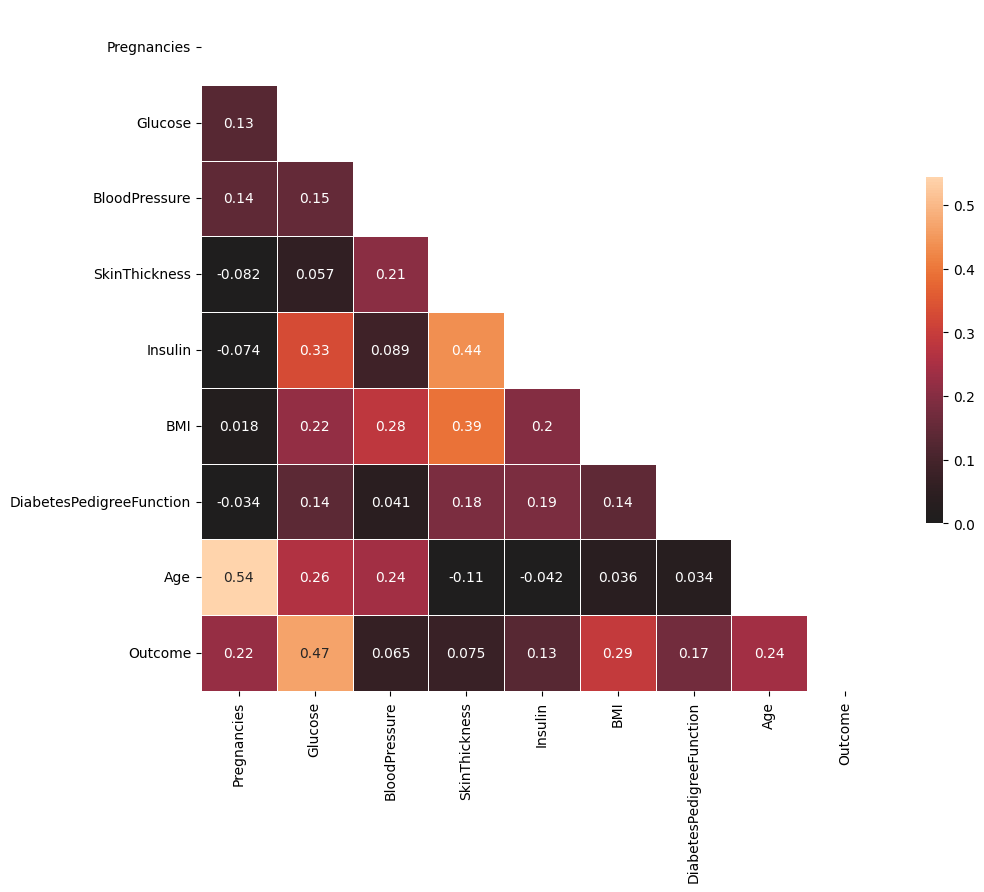

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin=0.0, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.show()


In [96]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [97]:
X = df.iloc[:,0:8].values
y = df.iloc[:,8].values


## (c) Vorbereitung eines Datensatzes in PyTorch: Dataset-Klasse

In PyTorch sind Datensätze und DataLoader essenziell, um Daten effizient für das Training und die Evaluation von Modellen bereitzustellen. Hier wird beschrieben, wie man einen eigenen Datensatz vorbereitet, ihn in ein `Dataset`-Objekt einbindet und mit einem `DataLoader` verwendet.
Zuerst müssen die Daten in geeignete PyTorch-Tensoren umgewandelt werden.
- **`X`**: Enthält die Eingabe-Features (z. B. Spalten 0–7 eines DataFrames).
- **`y`**: Enthält die Zielwerte (z. B. Spalte 8 eines DataFrames).
- **`dtype=torch.float32`**: Konvertiert die Daten in den Gleitkomma-Datentyp, der häufig in PyTorch verwendet wird.
- **`.to(device)`**: Verschiebt die Tensoren optional auf die GPU oder CPU, je nach Bedarf.

In [98]:

# Split into features (X) and target (y)
X = torch.tensor(df.iloc[:, 0:8].values, dtype=torch.float32).to(device)
y = torch.tensor(df.iloc[:, 8].values, dtype=torch.float32).unsqueeze(1).to(device)

#### **Erstellung einer benutzerdefinierten Dataset-Klasse**

PyTorch bietet die Möglichkeit, eigene Datensätze zu erstellen, indem man von der Klasse `torch.utils.data.Dataset` erbt. Dies ermöglicht die flexible Handhabung von Daten.

- **`__init__`**: Initialisiert die Klasse mit den Eingabedaten (`X`) und den Zielwerten (`y`).
- **`__len__`**: Gibt die Anzahl der Datenpunkte im Datensatz zurück.
- **`__getitem__`**: Ermöglicht den Zugriff auf die Datenpunkte über einen Index. Dies wird vom `DataLoader` verwendet, um Daten in Batches zu laden.


In [99]:
# Custom Dataset class
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## (d) Aufteilen in einen Trainings und Validierungsdatensatz & DataLoader

Teilen Sie den geladenen Datensatz in einen Trainings- und einen Testdatensatz auf (Aufteilung nach Zeilen) und verwenden Sie einen die Trainingsdaten (80%), um das Modell zu trainieren, und den Validierungsdatensatz (20%), um die Leistung des Modells auf neuen Daten zu schätzen. Erzeugen Sie einen `DataLoader` für die Trainings- und für die Validierungsdaten.


In [100]:
# Create dataset and split into train and validation sets
dataset = DiabetesDataset(X, y)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])




Ein `DataLoader` wird verwendet, um Daten in Mini-Batches zu laden und optional zufällig zu mischen.
- **`batch_size`**: Die Anzahl der Datenpunkte pro Batch.
- **`shuffle=True`**: Mischt die Daten zu Beginn jeder Epoche.

Der DataLoader kann in der Trainingsschleife verwendet werden, um Mini-Batches zu laden:

```python
for batch in dataloader:
    inputs, targets = batch
    # Weiterverarbeitung (z. B. Modellvorhersage und Verlustberechnung)
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    # Backpropagation und Optimierung
```

Dieses Vorgehen ermöglicht eine effiziente und skalierbare Verarbeitung von Datensätzen in PyTorch.

In [101]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [102]:
batch_size = 8
print_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
inputs, labels = next(iter(print_loader))  # Get the first batch

labels

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]])

## (e) Modell erstellen

In [103]:

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

model = Net().to(device)
# Assuming 'model' is your defined neural network
model = model.to(torch.float32)

In [104]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout layer after fc1
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout layer after fc2
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after activation
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after activation
        x = torch.sigmoid(self.fc3(x))
        return x

model = Net().to(device)
# Assuming 'model' is your defined neural network
model = model.to(torch.float32)


## (f) Modell darstellen

In [105]:
print(model)

Net(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [106]:
# Import required libraries
import torch
from torchsummary import summary
from torchviz import make_dot

# Summarize the model
summary(model, input_size=(1, 8))  # Adjust input_size as per your model's requirement

# Visualize the model architecture
x = torch.randn(1, 1, 8)  # Adjust input size as per your model's requirement
y = model(x)
make_dot(y, params=dict(model.named_parameters())).render("model_architecture", format="png")
from torchsummary import summary
from torchviz import make_dot

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           1,152
           Dropout-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
           Dropout-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 1]              65
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


## (g) Modell kompilieren und trainieren

In [107]:

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

# Training loop
epochs = 300
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = (output > 0.5).float()
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            predicted = (output > 0.5).float()
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')




Epoch [1/300], Train Loss: 3.6104, Train Acc: 53.58%, Val Loss: 0.7012, Val Acc: 62.34%
Epoch [2/300], Train Loss: 2.3415, Train Acc: 52.93%, Val Loss: 0.6569, Val Acc: 62.99%
Epoch [3/300], Train Loss: 1.4445, Train Acc: 59.61%, Val Loss: 0.6513, Val Acc: 63.64%
Epoch [4/300], Train Loss: 1.4283, Train Acc: 54.89%, Val Loss: 0.6641, Val Acc: 59.74%
Epoch [5/300], Train Loss: 0.8875, Train Acc: 58.31%, Val Loss: 0.6710, Val Acc: 61.04%
Epoch [6/300], Train Loss: 0.8381, Train Acc: 57.65%, Val Loss: 0.6716, Val Acc: 62.99%
Epoch [7/300], Train Loss: 0.7639, Train Acc: 58.96%, Val Loss: 0.6763, Val Acc: 62.34%
Epoch [8/300], Train Loss: 0.7486, Train Acc: 61.07%, Val Loss: 0.6735, Val Acc: 61.69%
Epoch [9/300], Train Loss: 0.7073, Train Acc: 61.56%, Val Loss: 0.6699, Val Acc: 61.69%
Epoch [10/300], Train Loss: 0.7060, Train Acc: 60.75%, Val Loss: 0.6704, Val Acc: 62.34%
Epoch [11/300], Train Loss: 0.6765, Train Acc: 63.36%, Val Loss: 0.6666, Val Acc: 62.34%
Epoch [12/300], Train Loss: 0.

In [108]:
# Evaluierung des Modells (Beispiel)
correct = 0
total = 0
with torch.no_grad():
    for data, target in train_loader:
        output = model(data)
        predicted = (output > 0.5).float()
        total += target.size(0)
        correct += (predicted == target).sum().item()

print('Accuracy: {}'.format(100 * correct / total))

Accuracy: 74.42996742671009


## (h) Modell abspeichern

Sie können Ihr Modell speichern, indem Sie die Funktion `save()` für das Modell aufrufen und den Dateinamen angeben.
Das folgende Beispiel demonstriert dies, indem zunächst ein Modell angepasst, ausgewertet und in der Datei "model.h5" gespeichert wird.

In [109]:
# Save the trained model
torch.save(model.state_dict(), 'diabetes_model.pth')

## (i) Modell laden

In [110]:
import torch
import torch.nn as nn


# Load the saved state dictionary
state_dict = torch.load('diabetes_model.pth')

# Create an instance of your model
model = Net()

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Now you can use the loaded model for inference or further training

<All keys matched successfully>

## (j) Lernkurven grafisch darstellen

Die Funktion `fit()` gibt ein `History`-Objekt zurück, das den Verlust und die Genauigkeit am Ende jeder Epoche zusammenfasst. Erstellen Sie Liniendiagramme dieser Daten, sogenannte Lernkurven.


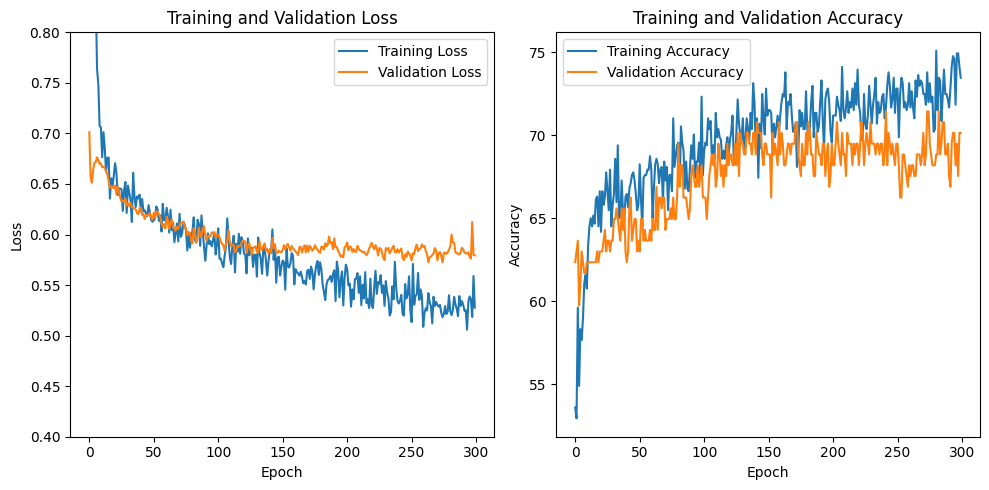

In [115]:
# Plot learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0.4, 0.8)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## (k) Trainieren auf einem neuen Datensatzes

Probieren Sie, einen anderen Tabellendatensatz zu verwenden, vielleicht aus dem UCI Machine Learning Repository.

## (l)  Das Modell anpassen

Ändern Sie die Konfiguration des Modells oder den Trainingsprozess und sehen Sie, ob Sie die Leistung des Modells verbessern können, z. B. eine Genauigkeit von mehr als 76 % erreichen.
